# Разработка методики анализа маршрутов движения транспортных потоков

### Цель исследования: Разработка методики анализа транспортных корреспонденций и характеристик транспортных потоков с применением систем фотовидеофиксации.

## Задачи исследования:
1. Рассмотреть методы построения матриц корреспонденций.
2. Рассмотреть методы сбора данных о транспортных корреспонденциях и характеристиках транспортного потока.
3. Произвести обзор инструментов обработки данных.
4. Разработать методику построения качественных матриц корреспонденции для пересечений и транспортных зон на основе комплексов фотовидеофиксации.*
5. Разработать алгоритм расчета основных параметров, характеризующих дорожное движение.*
6. Обеспечить интеграцию данных в геоинформационные системы.
7. Произвести расчет экономической эффективности от введения разработанной методики.

---
_* В рамках данной среды рассмотрены задача 4 и 5_ 

---
# <a name="contents">Этапы реализации:</a>
## [1. Подготовка данных](#stage_1)
## [2. Агрегация и первичная обработка данных](#stage_2)
## [3. Анализ маршрутов движения ТС](#stage_3)
## [4. Построение матриц корреспонденции](#stage_4)
## [5. Анализ средней скорости и плотности ТП на участке УДС](#stage_5)
## [6. Анализ интенсивности движения](#stage_6)
## [Заключение](#stage_7)

<a name='stage_1'><a/>
# Шаг 1. Подготовка данных
    
[Вернуться к оглавлению](#contents)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import glob
import datetime
import time

Выгрузка данных проводилась для 21-го пересечения г. Белгорода на дату 20.03.2023 в период с 7:00 до 9:00 часов. Всего для формирования базы для отработки методики было использовано 109 файлов формата “.xlsx”.

In [20]:
# создаем пустой датафрейм для хранения объединенных данных
all_files = pd.DataFrame()

# используем glob, чтобы получить список всех файлов .xlsx в каталоге
files = glob.glob(r'C:\Users\Max_Berdnikov\Desktop\Диплом\Данные с детекторов\Выгрузка 21.03\Выгрузка 21.03\А_Все общие файлы\*.xlsx')

# создаем цикл для добавления каждого файла в общий датафрейм
for file in files:
    df = pd.read_excel(file)
    all_files = pd.concat([all_files, df])
all_files = all_files.reset_index(drop=True)

In [21]:
all_files.head()

,Дата фиксации,Место фиксации,Направление,Полоса движения,ГРЗ,Скорость
0,2023-03-20 07:00:01,"Россия, Белгородская область, г. Белгород , пр...",К камере,2 (poly_2),T579MX31,NaN
1,2023-03-20 07:00:01,"Россия, Белгородская область, г. Белгород , пр...",К камере,2 (poly_2),P687BP31,NaN
2,2023-03-20 07:00:02,"Россия, Белгородская область, г. Белгород , пр...",К камере,2 (poly2),T358PA31,NaN
3,2023-03-20 07:00:07,"Россия, Белгородская область, г. Белгород , пр...",К камере,1 (poly1),X821CA31,NaN
4,2023-03-20 07:00:16,"Россия, Белгородская область, г. Белгород , пр...",К камере,2 (poly_2),K474MP31,NaN


In [22]:
all_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92223 entries, 0 to 92222
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Дата фиксации    92223 non-null  datetime64[ns]
 1   Место фиксации   92223 non-null  object        
 2   Направление      92223 non-null  object        
 3   Полоса движения  92223 non-null  object        
 4   ГРЗ              92223 non-null  object        
 5   Скорость         0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 4.2+ MB


In [24]:
all_files['Дата фиксации'] = pd.to_datetime(all_files['Дата фиксации'])

С помощью сортировки датафрейма по столбцу «Дата фиксации» мы получаем последовательность случаев фиксаций ТС на различных пересечениях, расположенную в хронологическом порядке. Это позволит корректно составить словари, содержащие информацию об индивидуальных маршрутах перемещений ТС и времени их фиксаций на конкретной точке. После сортировки обновляем индексацию строк

In [25]:
#Сортируем всю таблицу по времени, чтобы в дальнейшем при итерации точки маршрута выстраивались в правильном порядке
all_files = all_files.sort_values(['Дата фиксации'])
#Обновляем индексацию
all_files = all_files.reset_index(drop = True)

In [26]:
all_files.head()

,Дата фиксации,Место фиксации,Направление,Полоса движения,ГРЗ,Скорость
0,2023-03-20 07:00:00,"Россия, Белгородская область, г. Белгород , Ул...",К камере,2 (poly2),E957XH31,NaN
1,2023-03-20 07:00:00,"Россия, Белгородская область, г. Белгород , ул...",К камере,1 (poly1),O770KE31,NaN
2,2023-03-20 07:00:00,"Россия, Белгородская область, г. Белгород , ул...",К камере,2 (poly_2),O390BA31,NaN
3,2023-03-20 07:00:01,"Россия, Белгородская область, г. Белгород , пр...",К камере,2 (poly_2),T579MX31,NaN
4,2023-03-20 07:00:01,"Россия, Белгородская область, г. Белгород , пр...",К камере,2 (poly_2),P687BP31,NaN


In [27]:
all_files.drop_duplicates(subset=['ГРЗ', 'Дата фиксации'], inplace=True)

In [28]:
all_files.shape[0]

92223

Причиной возможной некорректной работы алгоритмов будет являться различная форма записи мест фиксаций, подразумевающих единое пересечение. Это приведёт к созданию дополнительных переменных и разделению цельных данных по отдельно взятому объекту УДС на несколько частей. Чтобы избежать этого, мы должны отобрать уникальные названия мест фиксации и привести их к единому виду

In [29]:
all_files['Место фиксации'].unique()

array(['Россия, Белгородская область, г. Белгород , Ул. Мичурина – ул. Садовая',
       'Россия, Белгородская область, г. Белгород , ул. Преображенская – ул. Чумичова',
       'Россия, Белгородская область, г. Белгород , ул. Попова – пр. Славы',
       'Россия, Белгородская область, г. Белгород , проспект Гражданский – ул. Белгородского полка',
       'Россия, Белгородская область, г. Белгород , Ул. Студенческая – ул. Некрасова',
       'Россия, Белгородская область, г. Белгород , Пр. Б.Хмельницкого – ул. Мичурина',
       'Россия, Белгородская область, г. Белгород, ул. Попова – пр. Славы',
       'Россия, Белгородская область, г. Белгород , Пр. Б.Хмельницкого – пр. Славы',
       'Россия, Белгородская область, г. Белгород , Пр. Б.Хмельницкого – ул. Невского',
       'Россия, Белгородская область, г. Белгород , Ул. Студенческая – ул. Садовая',
       'Россия, Белгородская область, г. Белгород , Пр. Б.Хмельницкого – Белгородский пр-т',
       'Россия, Белгородская область, г. Белгород ,

In [291]:
# До исправления вида записи в системе для единоразовой подготовки данные были обработаны построчно вручную
all_files['Место фиксации'] = all_files['Место фиксации'].replace('Россия, г. Белгород, Пр. Б.Хмельницкого – Белгородский пр-т', 
                                                            'Пр. Б.Хмельницкого – Белгородский пр-т')

In [20]:
# Сократим полное месторасположения до пересечения
all_files['Место фиксации'] = all_files['Место фиксации'].str.slice(start=44)

<a name='stage_2'><a/>
# Шаг 2. Агрегация и первичная обработка данных

[Вернуться к оглавлению](#contents)

In [30]:
# Прочитаем уже обработанный единый файл
all_files = pd.read_excel(r'C:\Users\Max_Berdnikov\Desktop\Диплом\Данные с детекторов\Выгрузка 21.03\df_all22(обработан).xlsx')

In [31]:
all_files.head()

,Дата фиксации,Место фиксации,Направление,Полоса движения,ГРЗ,Скорость
0,2023-03-20 07:00:00,Ул. Мичурина – ул. Садовая,К камере,2 (poly2),E957XH31,NaN
1,2023-03-20 07:00:00,Ул. Преображенская – ул. Чумичова,К камере,1 (poly1),O770KE31,NaN
2,2023-03-20 07:00:00,Ул. Попова – пр. Славы,К камере,2 (poly_2),O390BA31,NaN
3,2023-03-20 07:00:01,Гражданский пр. – ул. Белгородского полка,К камере,2 (poly_2),T579MX31,NaN
4,2023-03-20 07:00:01,Гражданский пр. – ул. Белгородского полка,К камере,2 (poly_2),P687BP31,NaN


In [32]:
unique_names = all_files['Место фиксации'].unique()
unique_names

array(['Ул. Мичурина – ул. Садовая', 'Ул. Преображенская – ул. Чумичова',
       'Ул. Попова – пр. Славы',
       'Гражданский пр. – ул. Белгородского полка',
       'Ул. Студенческая – ул. Некрасова',
       'Пр. Б.Хмельницкого – ул. Мичурина',
       'Пр. Б.Хмельницкого – пр. Славы',
       'Пр. Б.Хмельницкого – ул. Невского',
       'Ул. Студенческая – ул. Садовая',
       'Пр. Б.Хмельницкого – Белгородский пр.',
       'Пр. Б.Хмельницкого – ул. Преображенская',
       'Пр. Б.Хмельницкого – ул. Железнякова',
       'Пр. Славы – ул. Н.Чумичова',
       'Пр. Славы – ул. Белгородского полка',
       'Ул. Преображенская – ул. Белгородского полка',
       'Ул. Попова – ул. Преображенская', 'Ул. Попова – Белгородский пр.',
       'Пр. Белгородский – ул. Н. Чумичова',
       'Пр. Белгородский - ул. Белгородского полка',
       'Пр. Б.Хмельницкого – ул. Студенческая',
       'Пр. Славы – ул. Преображенская'], dtype=object)

Чтобы посмотреть перемещения отдельного ТС достаточно выбрать все строки датафрейма, в которых встречается запрашиваемый ГРЗ. Это может быть полезно в рамках проведения оперативно-розыскных мероприятий.

In [59]:
# Запрос случаев фиксаций по номеру ГРЗ
matches = all_files[all_files.iloc[:, 4] == input('Введите номер ГРЗ в формате Х000ХХ31: ')]
output_values = matches.iloc[:, [0, 1]]
output_values

Введите номер ГРЗ в формате Х000ХХ31: E890MO186


,Дата фиксации,Место фиксации
39,2023-03-20 07:00:10,Ул. Студенческая – ул. Садовая
184,2023-03-20 07:00:37,Ул. Студенческая – ул. Некрасова
320,2023-03-20 07:01:02,Пр. Б.Хмельницкого – ул. Студенческая
31954,2023-03-20 07:50:32,Пр. Б.Хмельницкого – ул. Преображенская
45578,2023-03-20 08:07:35,Пр. Б.Хмельницкого – пр. Славы
45830,2023-03-20 08:07:54,Пр. Б.Хмельницкого – ул. Преображенская
46407,2023-03-20 08:08:35,Пр. Б.Хмельницкого – Белгородский пр.
49014,2023-03-20 08:11:50,Пр. Б.Хмельницкого – ул. Студенческая
49929,2023-03-20 08:12:57,Ул. Студенческая – ул. Некрасова
56552,2023-03-20 08:20:58,Пр. Б.Хмельницкого – ул. Мичурина


In [33]:
# создадим массив array для всех уникальных номеров ГРЗ в выборке.
GRZ_list = all_files['ГРЗ'].unique()

Для оценки перемещений ТП следует изучить маршруты движения каждого ТС за рассматриваемый период времени. Предполагается **для каждого уникального номера ГРЗ создать пару ключ-значение**, ключом в которой выступает номер ГРЗ, а значение содержит информацию о списке пересечений, на которых было зафиксировано ТС, и времени его фиксации. Это позволит заложить основу для дальнейшего анализа. В коде это достигается путем создания двух словарей: all_track_dict и fixation_moment_dict.

Словарь **all_track_dict** сопоставляет каждое уникальное значение ГРЗ **со списком пересечений**, на которых было зафиксировано ТС, а словарь **fixation_moment_dict** сопоставляет каждое уникальное значение ГРЗ со списком **времени фиксации ТС** на определенном пересечении. 

In [34]:
#создаем список маршрутов по каждому ГРЗ
import time 
start = time.time() ## точка отсчета времени


all_track_dict = {}            #словарь - {[ГРЗ : название пересечения1, пересечения2...], ...}
fixation_moment_dict = {}      #словарь - {[ГРЗ : время проезда пересечения1, пересечения2], ...}
for index, row in all_files.iterrows():
    grz = row['ГРЗ']
    crossroad = row['Место фиксации']
    fixation_moment = row['Дата фиксации']
    if grz in all_track_dict:
        all_track_dict[grz].append(crossroad)
        fixation_moment_dict[grz].append(str(fixation_moment))
    else:
        all_track_dict[grz] = [crossroad]
        fixation_moment_dict[grz] = [str(fixation_moment)]

all_track_list = list(all_track_dict.values())

end = time.time() - start ## собственно время работы программы
print(end)

15.288151979446411


In [35]:
all_track_list[:3]

[['Ул. Мичурина – ул. Садовая', 'Ул. Мичурина – ул. Садовая'],
 ['Ул. Преображенская – ул. Чумичова', 'Пр. Белгородский – ул. Н. Чумичова'],
 ['Ул. Попова – пр. Славы', 'Ул. Студенческая – ул. Некрасова']]

<a name='stage_3'><a/>
# Шаг 3. Анализ маршрутов движения ТС
    
[Вернуться к оглавлению](#contents)

Теперь, когда нам удалось определить маршруты движения для каждого ТС, необходимо систематизировать полученную информацию. Определим все уникальные маршруты и выполним подсчет ТС, которые двигались по ним.

In [43]:
#Подсчет количества ТС проехавшим по уникальным маршрутам
all_track_tuple = [tuple(sublist) for sublist in all_track_list]

count_track_dict = {}
for item in all_track_tuple:
    if item in count_track_dict:
        count_track_dict[item] += 1
    else:
        count_track_dict[item] = 1

#Создаем датафрейм для маршрутов и количества ТС, проехавшим по ним
count_track_list = []
for key, value in count_track_dict.items():
    if len(key) > 1:    #Отбрасываем те случаи, где ТС было зафиксировано только на 1-ом пересечении
        count_track_tuple = [key, value]
        count_track_list.append(count_track_tuple)
        
track_count_df = pd.DataFrame(count_track_list, columns=['Маршрут', 
                                                         'Количество ТС'])
track_count_df.sort_values(by='Количество ТС', ascending=False, inplace=True)

In [44]:
track_count_df

,Маршрут,Количество ТС
45,"(Ул. Студенческая – ул. Садовая, Ул. Студенчес...",425
97,"(Ул. Студенческая – ул. Некрасова, Ул. Студенч...",222
780,"(Пр. Б.Хмельницкого – пр. Славы, Пр. Б.Хмельни...",208
440,"(Пр. Б.Хмельницкого – ул. Невского, Пр. Б.Хмел...",197
499,"(Пр. Б.Хмельницкого – ул. Невского, Пр. Б.Хмел...",187
...,...,...
2845,"(Пр. Б.Хмельницкого – пр. Славы, Ул. Попова – ...",1
2844,"(Пр. Б.Хмельницкого – ул. Невского, Пр. Б.Хмел...",1
2843,"(Пр. Б.Хмельницкого – ул. Железнякова, Пр. Б.Х...",1
2841,"(Пр. Белгородский – ул. Н. Чумичова, Ул. Преоб...",1


Text(0.5, 1.0, 'Количество ТС, проехавшим по данным маршрутам')

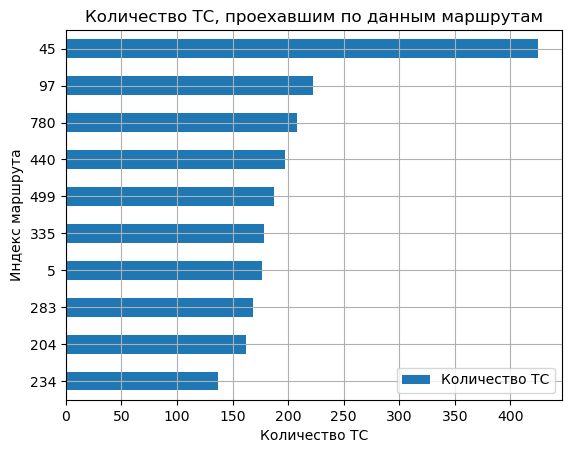

In [49]:
track_count_df.head(10).sort_values('Количество ТС').plot(kind="barh", grid=True)
plt.ylabel('Индекс маршрута')
plt.xlabel('Количество ТС')
plt.title('Количество ТС, проехавшим по данным маршрутам')

In [52]:
track_count_df.loc[45]['Маршрут']

('Ул. Студенческая – ул. Садовая',
 'Ул. Студенческая – ул. Некрасова',
 'Пр. Б.Хмельницкого – ул. Студенческая')

**Вывод**

На основании получившегося датафрейма мы построили график, используя 10 наиболее загруженных маршрутов в качестве входных данных. Мы выявили наиболее загруженную последовательность фиксаций - маршрут с индексом 45 и определили точки фиксаций.

<a name='stage_4'><a/>
# Шаг 4. Построение матриц корреспонденции
    
[Вернуться к оглавлению](#contents)

## Шаг 4.1. Построение матриц корреспонденции для отдельно взятых пересечений

In [53]:
# Создание пустой матрицы
matrix = pd.DataFrame(index=unique_names, columns=unique_names)
matrix.fillna(0, inplace=True)    #заполняем таблицу нулями

# Заполнение матрицы корреспонденций 
counter_1 = 0      
for i in range(len(all_track_list)):
    if len(all_track_list[i]) > 1:
        for j in range(len(all_track_list[i]) - 1):
            matrix.loc[all_track_list[i][j], all_track_list[i][j + 1]] += 1
    else:
        counter_1 += 1

In [55]:
matrix.head()

,Ул. Мичурина – ул. Садовая,Ул. Преображенская – ул. Чумичова,Ул. Попова – пр. Славы,Гражданский пр. – ул. Белгородского полка,Ул. Студенческая – ул. Некрасова,Пр. Б.Хмельницкого – ул. Мичурина,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Невского,Ул. Студенческая – ул. Садовая,Пр. Б.Хмельницкого – Белгородский пр.,...,Пр. Б.Хмельницкого – ул. Железнякова,Пр. Славы – ул. Н.Чумичова,Пр. Славы – ул. Белгородского полка,Ул. Преображенская – ул. Белгородского полка,Ул. Попова – ул. Преображенская,Ул. Попова – Белгородский пр.,Пр. Белгородский – ул. Н. Чумичова,Пр. Белгородский - ул. Белгородского полка,Пр. Б.Хмельницкого – ул. Студенческая,Пр. Славы – ул. Преображенская
Ул. Мичурина – ул. Садовая,553,7,10,11,126,631,3,26,283,40,...,52,1,3,13,58,330,255,68,69,11
Ул. Преображенская – ул. Чумичова,22,38,59,20,0,25,55,0,1,37,...,2,447,9,3,901,4,505,14,3,71
Ул. Попова – пр. Славы,72,62,76,91,1,11,32,2,2,32,...,0,1191,141,11,571,10,17,4,2,11
Гражданский пр. – ул. Белгородского полка,19,49,56,292,6,5,29,6,67,25,...,4,66,1166,499,31,7,304,84,1,14
Ул. Студенческая – ул. Некрасова,89,2,0,7,402,77,1,27,1093,23,...,27,1,0,3,0,4,6,3,1141,4


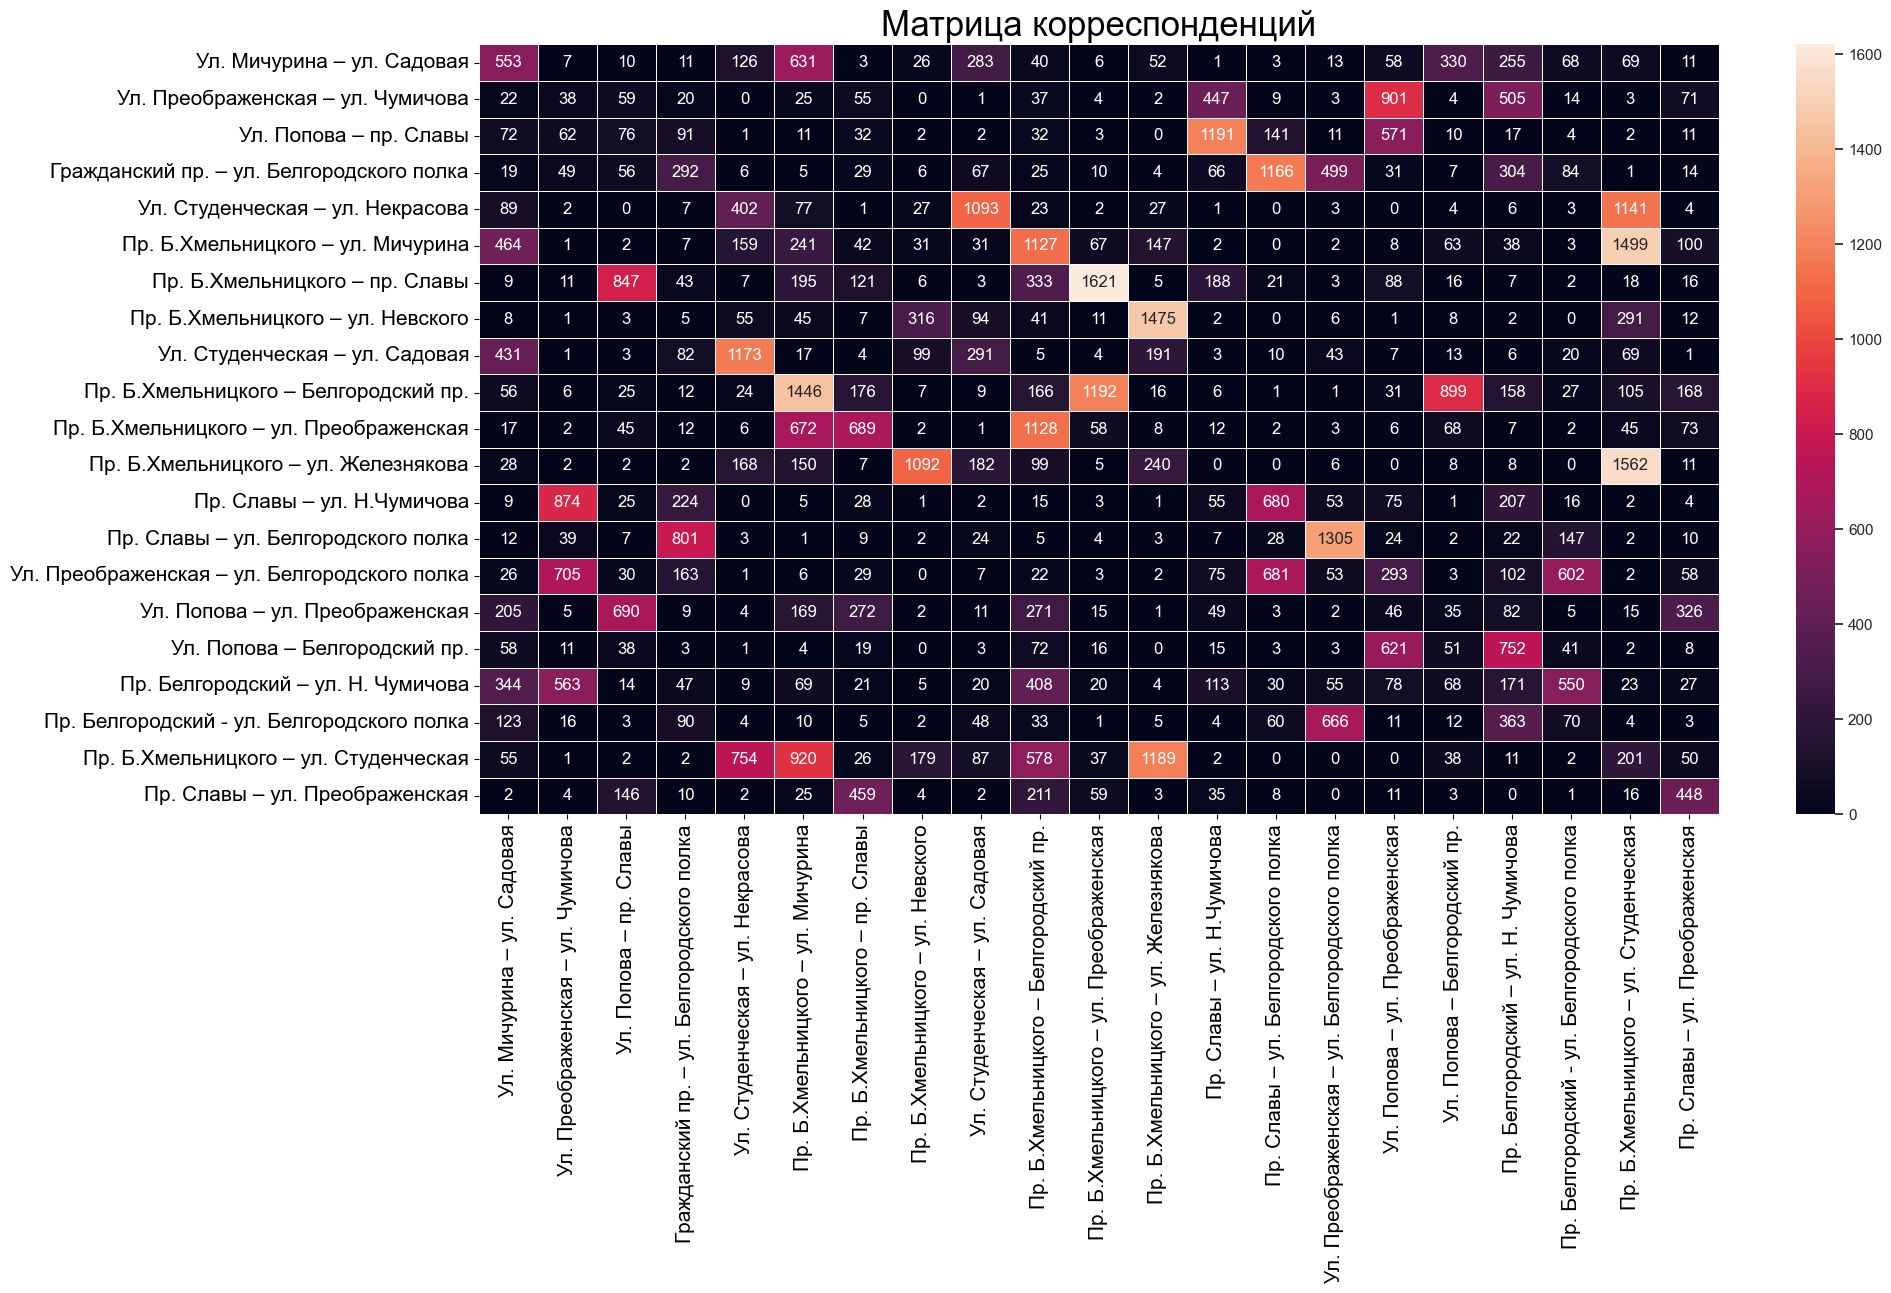

In [56]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(matrix, linewidths=0.5, annot=True, fmt='d')
plt.title('Матрица корреспонденций', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize= 15)
fig.savefig(r'C:\Users\Max_Berdnikov\Desktop\matrix2.png', bbox_inches = 'tight', transparent=True, dpi=300)

Итоговый датафрейм представляет собой матрицу 21х21, которая наглядно демонстрирует количество перемещений ТС. Далее для упрощения анализа и интеграции полученных данных необходимо преобразовать матричный фрейм данных из широкого формата в длинный.

In [57]:
s = matrix.stack()
new_matrix = s.reset_index()
new_matrix.columns = ['Начальная точка', 'Конечная точка', 'Кол-во ТС']
new_matrix

,Начальная точка,Конечная точка,Кол-во ТС
0,Ул. Мичурина – ул. Садовая,Ул. Мичурина – ул. Садовая,553
1,Ул. Мичурина – ул. Садовая,Ул. Преображенская – ул. Чумичова,7
2,Ул. Мичурина – ул. Садовая,Ул. Попова – пр. Славы,10
3,Ул. Мичурина – ул. Садовая,Гражданский пр. – ул. Белгородского полка,11
4,Ул. Мичурина – ул. Садовая,Ул. Студенческая – ул. Некрасова,126
...,...,...,...
436,Пр. Славы – ул. Преображенская,Ул. Попова – Белгородский пр.,3
437,Пр. Славы – ул. Преображенская,Пр. Белгородский – ул. Н. Чумичова,0
438,Пр. Славы – ул. Преображенская,Пр. Белгородский - ул. Белгородского полка,1
439,Пр. Славы – ул. Преображенская,Пр. Б.Хмельницкого – ул. Студенческая,16


## Шаг 4.2. Построение матриц корреспонденции для транспортных зон

Теперь мы можем изучить перемещение ТС между отдельно взятыми пересечениями, однако в рамках транспортного планирования преимущественно рассматриваются движение ТП между различными районами города.

In [59]:
# Определяем транспортные зоны и принадлежащие им пересечения улиц
t_areas = {
    1: ['Ул. Преображенская – ул. Чумичова', 'Ул. Попова – пр. Славы', 'Гражданский пр. – ул. Белгородского полка',
       'Пр. Б.Хмельницкого – пр. Славы', 'Пр. Б.Хмельницкого – Белгородский пр.', 'Пр. Б.Хмельницкого – ул. Преображенская',
       'Пр. Славы – ул. Н.Чумичова', 'Пр. Славы – ул. Белгородского полка', 'Ул. Преображенская – ул. Белгородского полка',
       'Ул. Попова – ул. Преображенская', 'Ул. Попова – Белгородский пр.', 'Пр. Белгородский – ул. Н. Чумичова',
       'Пр. Белгородский - ул. Белгородского полка'],
    2: ['Ул. Мичурина – ул. Садовая', 'Ул. Студенческая – ул. Некрасова', 'Пр. Б.Хмельницкого – ул. Мичурина',
       'Пр. Б.Хмельницкого – ул. Невского', 'Ул. Студенческая – ул. Садовая'],
    3: ['Пр. Б.Хмельницкого – ул. Железнякова', 'Пр. Б.Хмельницкого – ул. Студенческая', 'Пр. Славы – ул. Преображенская']}

# Создание матрицы
num_zones = len(t_areas)
area_matrix_df = pd.DataFrame({'Начальная зона': np.repeat(np.arange(1, num_zones+1), num_zones), 'Конечная зона': np.tile(np.arange(1, num_zones+1), num_zones),'Количество ТС': np.zeros(num_zones**2, dtype=int)})

# перебираем все маршруты
for track in all_track_list:
    for i in range(len(track) - 1):
        start_zone = None
        end_zone = None
        # Определяем зону, содержащую начальное пересечение
        for zone, intersections in t_areas.items():
            if track[i] in intersections:
                start_zone = zone
                break
        # Определяем зону, содержащую конечное пересечение
        for zone, intersections in t_areas.items():
            if track[i+1] in intersections:
                end_zone = zone
                break
        if start_zone is not None and end_zone is not None:
            # Обновляем подсчет в матрице, используя id зон
            area_matrix_df.loc[(area_matrix_df['Начальная зона'] == start_zone) &
            (area_matrix_df['Конечная зона'] == end_zone), 'Количество ТС'] += 1

In [60]:
area_matrix_df.rename(columns = {'Начальная зона':'origin_id', 
                                 'Конечная зона':'destinatio', 
                                 'Количество ТС':'moving'}, inplace = True)

In [62]:
area_matrix_df.head()

,origin_id,destinatio,moving
0,1,1,29008
1,1,2,3889
2,1,3,1064
3,2,1,2507
4,2,2,6762


Импортируем подготовленный .shp файл и с помощью библиотеки Geopandas обновляем атрибутивную информацию, добавив новый столбец с количеством перемещений ТС. Открываем перезаписанный линейный слой и подгружаем заранее подготовленный стиль .qml формата.

In [69]:
matrix_area = gpd.read_file(r'C:\Users\Max_Berdnikov\Desktop\Диплом\Qgis\shp для pandas (пересечения)\Area_matrix.shp', encoding = 'utf-8')

In [70]:
matrix_area

,origin_id,destinatio,entry_cost,network_co,exit_cost,total_cost,moving,geometry
0,3,3,0.000000,0.000000,0.000000,0.000000,3720,None
1,3,2,0.000122,0.015636,0.000519,0.016278,3650,"LINESTRING (36.55819 50.61852, 36.58770 50.61792)"
2,3,1,0.000122,0.022819,0.000287,0.023229,1785,"LINESTRING (36.55819 50.61852, 36.58469 50.59888)"
...,...,...,...,...,...,...,...,...
6,1,3,0.000287,0.022819,0.000122,0.023229,1064,"LINESTRING (36.58469 50.59888, 36.55819 50.61852)"
7,1,2,0.000287,0.018977,0.000519,0.019783,3889,"LINESTRING (36.58469 50.59888, 36.58770 50.61792)"
8,1,1,0.000000,0.000000,0.000000,0.000000,29008,"LINESTRING (36.58469 50.59888, 36.58770 50.61792)"


In [65]:
matrix_area = matrix_area.astype({'origin_id': np.int64, 'destinatio': np.int64})

In [55]:
merged_area = matrix_area.merge(area_matrix_df, on=['origin_id', 'destinatio'])

In [68]:
merged_area.to_file(r'C:\Users\Max_Berdnikov\Desktop\Диплом\Qgis\shp для pandas (пересечения)\Area_matrix.shp')

<a name='stage_5'><a/>
# Шаг 5. Анализ средней скорости и плотности ТП на участке УДС
    
[Вернуться к оглавлению](#contents)

* Используемый в данной работе подход основывается на методических рекомендациях по проведению мониторинга дорожного движения, где средняя скорость определяется исходя из протяженности участка и разницы времени моментов фиксаций при выезде и въезде на него

* Как правило, средняя скорость ТС на участке дороги рассчитывается путем взятия среднего арифметического от фиксаций мгновенной скорости всех ТС, движущихся в одном направлении. Зачастую такой подход не может гарантировать объективную оценку средней скорости на участке УДС и зависит от протяженности участка и места установки камеры.

* Для выстраивания дальнейших связей была создана вспомогательная таблица с уникальными идентификаторами участков УДС и направлениями движения. Кроме того, эта информация понадобится для импорта полученных данных в ГИС и обратного импорта расчета длины ребер в датафрейм.

In [72]:
edge_id_df = pd.read_excel(r'C:\Users\Max_Berdnikov\Desktop\Диплом\pandas\id_ребер.xlsx')

In [73]:
edge_id_df.head()

,Начальная точка,Конечная точка,ngw_id,Направление
0,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1,AB
1,Пр. Б.Хмельницкого – ул. Преображенская,Пр. Б.Хмельницкого – пр. Славы,1,BA
2,Пр. Б.Хмельницкого – ул. Преображенская,Пр. Б.Хмельницкого – Белгородский пр.,3,AB
3,Пр. Б.Хмельницкого – Белгородский пр.,Пр. Б.Хмельницкого – ул. Преображенская,3,BA
4,Ул. Попова – пр. Славы,Ул. Попова – ул. Преображенская,17,AB


In [74]:
edge_dict = edge_id_df.set_index(['Начальная точка', 
'Конечная точка'])['ngw_id'].to_dict()

def generate_entries():
    for key, track in all_track_dict.items():
        for i in range(len(track) - 1):
            start_point = track[i]
            end_point = track[i + 1]
            edge_id = edge_dict.get((start_point, end_point))
            if edge_id is not None:
                time1 = datetime.datetime.strptime(fixation_moment_dict[key][i],
                                                   '%Y-%m-%d %H:%M:%S')
                time2 = datetime.datetime.strptime(fixation_moment_dict[key][i + 1], 
                                                   '%Y-%m-%d %H:%M:%S')
                time_diff = (time2 - time1).seconds
                yield {'ГРЗ': key, 'Время движения(Δt), с.': time_diff, 
                       'Время въезда на участок': fixation_moment_dict[key][i], 
                       'Начальная точка': start_point, 
                       'Конечная точка': end_point, 
                       'ngw_id': edge_id}

df_edge = pd.DataFrame(generate_entries())
df_edge['Время въезда на участок'] = pd.to_datetime(
df_edge['Время въезда на участок'], format='%Y-%m-%d %H:%M:%S')


In [76]:
df_edge.head()

,ГРЗ,"Время движения(Δt), с.",Время въезда на участок,Начальная точка,Конечная точка,ngw_id
0,O770KE31,71,2023-03-20 07:00:00,Ул. Преображенская – ул. Чумичова,Пр. Белгородский – ул. Н. Чумичова,27
1,B004EP31,78,2023-03-20 08:26:37,Пр. Б.Хмельницкого – ул. Невского,Пр. Б.Хмельницкого – ул. Железнякова,8
2,B004EP31,106,2023-03-20 08:27:55,Пр. Б.Хмельницкого – ул. Железнякова,Пр. Б.Хмельницкого – ул. Студенческая,4
3,O802TE31,35,2023-03-20 07:00:01,Ул. Попова – пр. Славы,Ул. Попова – ул. Преображенская,17
4,A665EC198,60,2023-03-20 07:42:31,Пр. Белгородский - ул. Белгородского полка,Пр. Белгородский – ул. Н. Чумичова,24


* Для определения параметров средней скорости и плотности на каждом ребре достаточно, используя данные о протяженности участков дорог и группируя датафрейм по идентификатору ребра и направлению, добавить рассчитанные столбцы, однако стоит учитывать влияние на конечный результат ошибочных данных.

* Пример дальнейшего анализа данных будет продемонстрирован на участке пр. Б. Хмельницкого от пр. Славы до ул. Преображенской, для которого имеются данные фиксаций в течение 24-х часов.


In [77]:
all_files = pd.read_excel(r'C:\Users\Max_Berdnikov\Desktop\Диплом\Данные с детекторов\Выгрузка 05.04\Общий.xlsx')

In [81]:
all_files.head()

,Дата фиксации,Место фиксации,Направление,Полоса движения,ГРЗ,Скорость
0,2023-03-20 00:00:00,Пр. Б.Хмельницкого – пр. Славы,К камере,3 (poly_3),B825XO91,NaN
1,2023-03-20 00:00:03,Пр. Б.Хмельницкого – ул. Преображенская,К камере,2 (poly2),165DNA15,NaN
2,2023-03-20 00:00:11,Пр. Б.Хмельницкого – ул. Преображенская,К камере,4 (poly4),P825XO31,NaN
3,2023-03-20 00:00:13,Пр. Б.Хмельницкого – ул. Преображенская,К камере,3 (poly3),X926AX31,NaN
4,2023-03-20 00:00:15,Пр. Б.Хмельницкого – ул. Преображенская,К камере,4 (poly4),K414KK31,NaN


In [78]:
all_track_dict = {}            
fixation_moment_dict = {}      
for index, row in all_files.iterrows():
    grz = row['ГРЗ']
    crossroad = row['Место фиксации']
    fixation_moment = row['Дата фиксации']
    if grz in all_track_dict:
        all_track_dict[grz].append(crossroad)
        fixation_moment_dict[grz].append(str(fixation_moment))
    else:
        all_track_dict[grz] = [crossroad]
        fixation_moment_dict[grz] = [str(fixation_moment)]

all_track_list = list(all_track_dict.values())

In [82]:
df_edge = pd.DataFrame(generate_entries())
df_edge['Время въезда на участок'] = pd.to_datetime(df_edge['Время въезда на участок'], format='%Y-%m-%d %H:%M:%S')
df_edge['Начальная точка'] = Point_A
df_edge['Конечная точка'] = Point_B

In [84]:
df_edge.head()

,ГРЗ,"Время движения(Δt), с.",Время въезда на участок,Начальная точка,Конечная точка,ngw_id
0,K414KK31,77,2023-03-20 08:50:10,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1
1,K414KK31,11,2023-03-20 14:05:39,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1
2,Y757BH31,33949,2023-03-20 00:00:23,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1
3,Y757BH31,16,2023-03-20 09:26:12,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1
4,Y180BE31,69752,2023-03-20 00:00:26,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1


Text(0.5, 1.0, 'Распределение ТС в зависимости от времени прохождения участка')

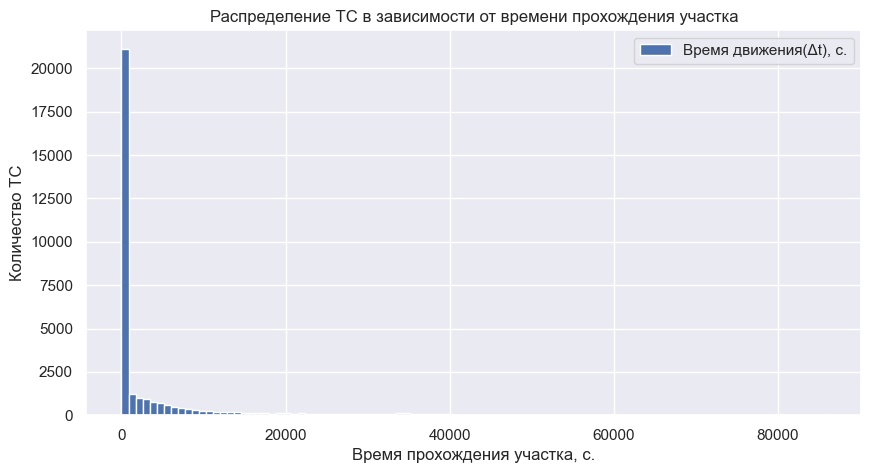

In [85]:
df_edge.plot(kind='hist', y='Время движения(Δt), с.', bins=100, figsize=(10, 5))
plt.xlabel('Время прохождения участка, с.')
plt.ylabel('Количество ТС')
plt.title('Распределение ТС в зависимости от времени прохождения участка')

Можно наблюдать, что основная часть данных находится в первой корзине, а справа от нее длинный хвост с более редкими величинами. В данном случае, учитывая специфику исследований, график имеет вид распределения Пуассона.

Возможными причинами регистрации экстремально большого времени прохождения участков могут быть: 
- Остановка или парковка ТС после прохождения начальной точки фиксации;
- Пропуск фиксации на конечной точке, фиксация на ней при движении в обратном направлении;
- Съезд с участка в область, где отсутствуют комплексы регистрации, возвращение через конечную точку ребра.


Text(0.5, 0, 'Время движения по участку, с.')

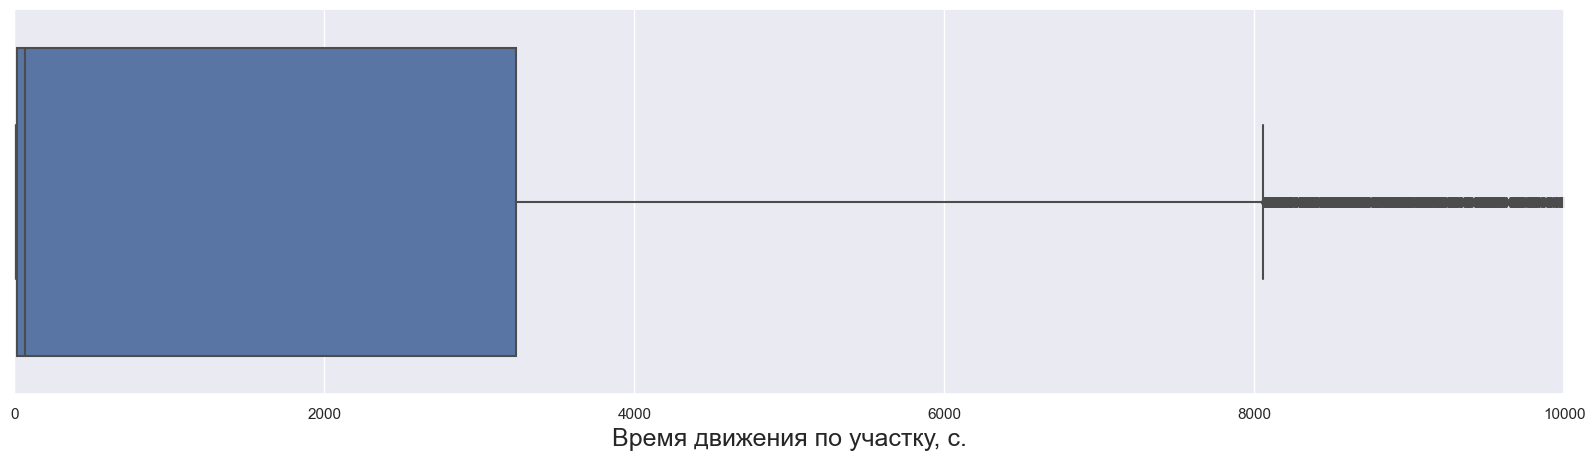

In [86]:
plt.figure(figsize=(20, 5))
plt.xlim(0, 10000) 
sns.boxplot(x=df_edge['Время движения(Δt), с.'])
plt.xlabel('Время движения по участку, с.', fontsize=18)

<Axes: xlabel='Время движения(Δt), с.'>

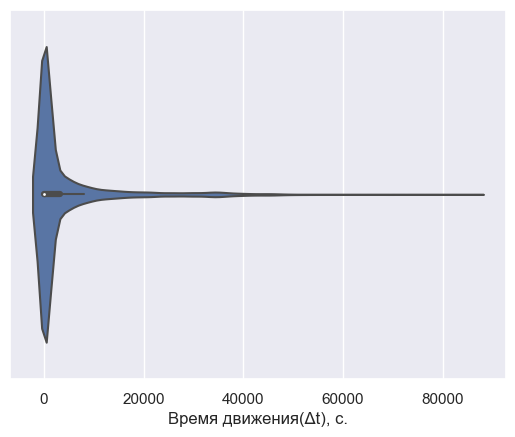

In [87]:
sns.violinplot(x=df_edge['Время движения(Δt), с.'])

In [89]:
df_edge['Время движения(Δt), с.'].describe()

count    32129.000000
mean      4068.987488
std       9200.973583
min          2.000000
25%         19.000000
50%         70.000000
75%       3235.000000
max      85848.000000
Name: Время движения(Δt), с., dtype: float64

**Вывод**

межквартильный размах принимает значения **от 15 до 1703 секунд**. Учитывая специфику дорожного движения и протяженность данного участка (135 метров), можно сделать вывод, что граница выбросов находится между 2-ым и 3-им квартилем. На диаграмме размаха медиана сильно стремится к 1-му квартилю, что также указывает на это, так как она в меньшей степени подвержена влиянию выбросов. Полльзоваться стандарными методами очистки данных от выбросов при нынешнем уровне процента распознавания ГРЗ некорректно. Исходя из эмпирически полученных данных установим границу для этого участка в **200 секунд**.

Для уточнения этой границы и оценки корректности конечной выборки мы используем диаграмму рассеяния, отражающую изменение времени прохождения участка в течение суток. Опишем график и сформируем возможные гипотезы движения ТС на данном участке УДС

In [91]:
df_edge_new = df_edge.loc[df_edge['Время движения(Δt), с.'] <= 200].sort_values(by='Время движения(Δt), с.')

Text(0.5, 1.0, 'Распределение случаев прохождения учстка за определенное время')

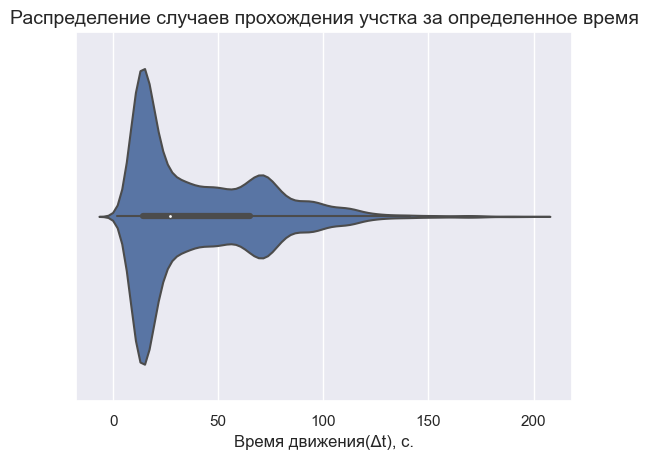

In [92]:
sns.violinplot(x=df_edge_new['Время движения(Δt), с.'])
plt.title('Распределение случаев прохождения учстка за определенное время', fontsize=14)

In [93]:
# Добавляем столбец с округленным до часов временем. Сделаем разбивку по часам в сутках
df_edge_new['date_hour'] = df_edge_new['Время въезда на участок'].dt.floor('1H')

In [94]:
#Добавляем столбец средней скорости
df_edge_new['Средняя скорость, км/ч'] = 0.135 / (df_edge_new['Время движения(Δt), с.'] / 3600)

In [114]:
df_edge_new.sort_values(by='Время въезда на участок').head()

,ГРЗ,"Время движения(Δt), с.",Время въезда на участок,Начальная точка,Конечная точка,ngw_id,date_hour,"Средняя скорость, км/ч"
12,M733MB31,58,2023-03-20 00:01:53,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1,2023-03-20,8.37931
14,Y738BH31,50,2023-03-20 00:01:59,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1,2023-03-20,9.72000
16,T069MO31,40,2023-03-20 00:02:05,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1,2023-03-20,12.15000
26,H260TT31,16,2023-03-20 00:02:31,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1,2023-03-20,30.37500
28,K023OE174,16,2023-03-20 00:02:39,Пр. Б.Хмельницкого – пр. Славы,Пр. Б.Хмельницкого – ул. Преображенская,1,2023-03-20,30.37500


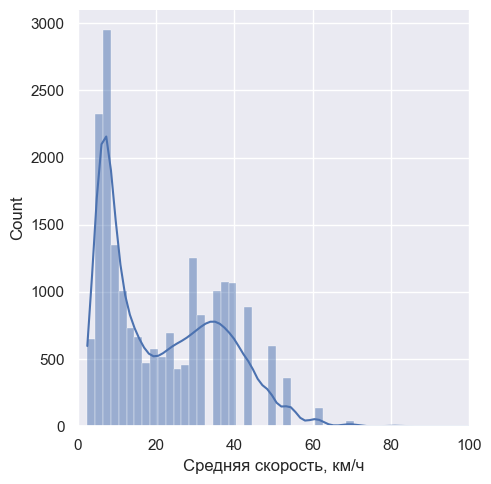

In [123]:
g = sns.displot(df_edge_new['Средняя скорость, км/ч'], kde=True)
g.set(xlim=(0, 100))

Можно предположить, что на графике 2 пика представляю собой движение пачек автомобилей с равномерной скоростью: наибольшая группа – движение в прямом направлении по пр. Б. Хмельницкого, меньшая – поворот с пр. Славы

In [110]:
import matplotlib.dates as mdates

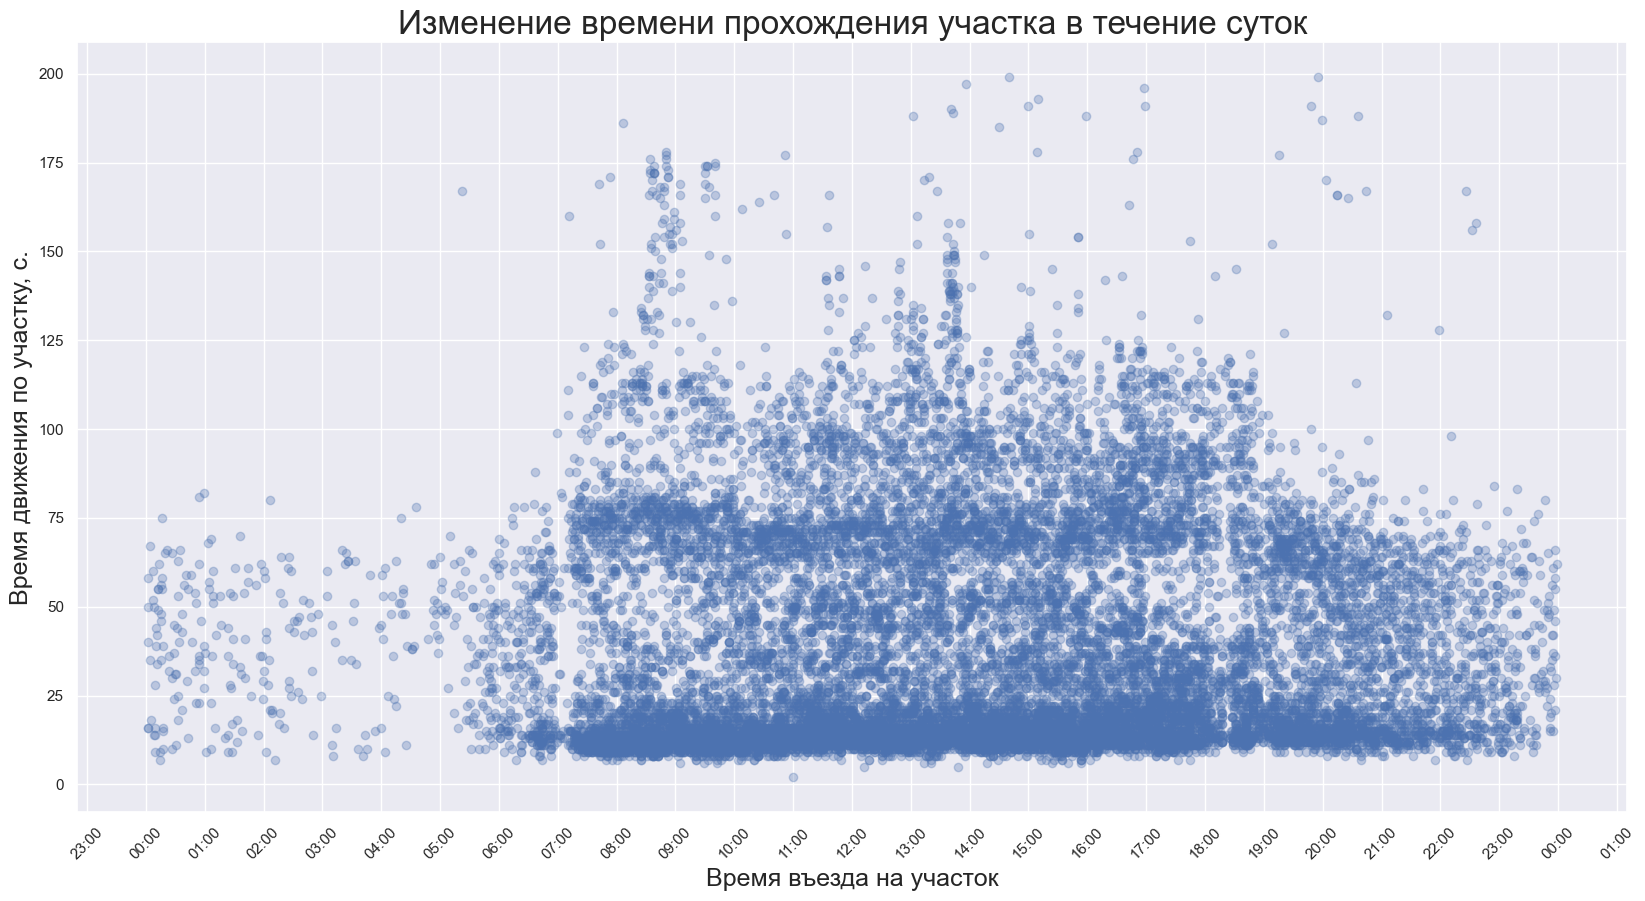

In [111]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_edge_new['Время въезда на участок'], df_edge_new['Время движения(Δt), с.'], 'o', alpha=0.3)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel('Время въезда на участок', fontsize=18)
plt.ylabel('Время движения по участку, с.', fontsize=18)
plt.title('Изменение времени прохождения участка в течение суток', fontsize=24)
plt.xticks(rotation=45)
plt.show()

**Выводы**

На графике отчетливо видно характерные временные диапазоны: 
- В ночное время (00:00 – 05:30) количество точек гораздо меньше и отсутствуют области их скопления, что объясняется низкой интенсивностью движения и, как следствие, попаданием ТС на различные временные промежутки фаз светофорного регулирования. 
- На следующем промежутке (05:30 – 07:00) наблюдается постепенное увеличение интенсивности движения и появление первых скоплений точек. 
- Между утренним и вечерним часом пик (7:00 – 18:30) при рассмотрении в данном масштабе прослеживается единая закономерность: наиболее плотное облако точек в районе 15 секунд и менее плотная группа точек около 75 секунд. Ввиду высокой загруженности этого участка дороги можно предположить, что на графике участки с высокой плотностью представляю собой движение пачек автомобилей с равномерной скоростью: наибольшая группа – движение в прямом направлении по пр. Б. Хмельницкого, меньшая – поворот с пр. Славы. 
- В вечернее время (18:30 – 00:00) можно видеть постепенное уменьшение количества точек и их рассредоточение, пропадают случаи прохождения участка дольше 90 секунд.

На основе конечной выборки мы можем рассчитать среднее время 

In [116]:
# Создаем разбивку по часам для измерения ср. скорости и плотности
df_edge_new['date_hour'] = df_edge_new['Время въезда на участок'].dt.floor('1H')
time_division = df_edge_new.pivot_table(index='date_hour', 
                                        values='Время движения(Δt), с.', 
                                        aggfunc=['mean', 'count'])
time_division.columns = ['Среднее время движения, с.', 'Кол-во фиксаций']
time_division['Средняя скорость, км/ч'] = round(0.135 / (
    time_division['Среднее время движения, с.'] / 3600), 2)
time_division['Плотность, ед/км'] = round(time_division['Кол-во фиксаций'] / (
    time_division['Средняя скорость, км/ч'] * 2), 2)
time_division = time_division.reset_index()
time_division.head()

,date_hour,"Среднее время движения, с.",Кол-во фиксаций,"Средняя скорость, км/ч","Плотность, ед/км"
0,2023-03-20 00:00:00,39.804878,82,12.21,3.36
1,2023-03-20 01:00:00,37.306122,49,13.03,1.88
2,2023-03-20 02:00:00,38.365854,41,12.67,1.62
3,2023-03-20 03:00:00,38.407407,27,12.65,1.07
4,2023-03-20 04:00:00,45.805556,36,10.61,1.70


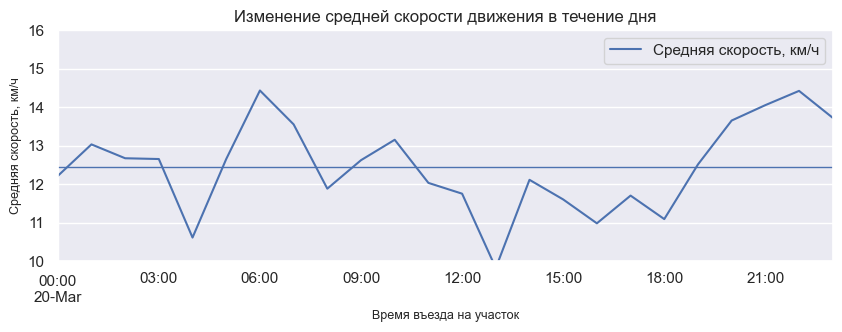

In [117]:
time_division.plot(x='date_hour', y='Средняя скорость, км/ч', figsize=(10, 3))
plt.xlabel('Время въезда на участок', fontsize=9)
plt.ylabel('Средняя скорость, км/ч', fontsize=9)
plt.axhline (y=np.nanmean(time_division['Средняя скорость, км/ч']), linewidth=1)
plt.ylim(10, 16)
plt.title('Изменение средней скорости движения в течение дня')
plt.show()

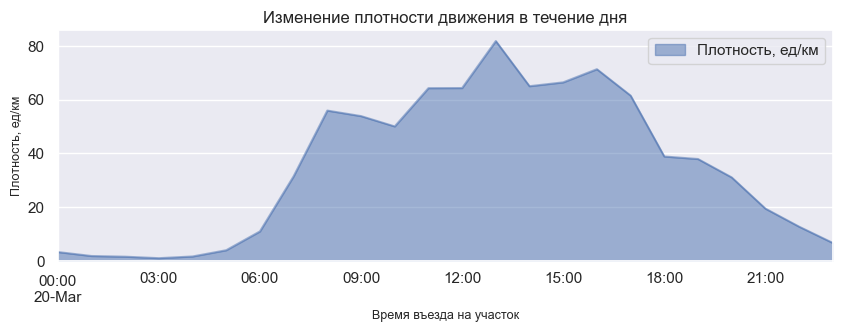

In [118]:
#В Приложение, изменение плотности
time_division.plot.area(x='date_hour', y='Плотность, ед/км', figsize=(10, 3), stacked=False, grid=True)
plt.xlabel('Время въезда на участок', fontsize=9)
plt.ylabel('Плотность, ед/км', fontsize=9)
plt.title('Изменение плотности движения в течение дня')
plt.show()

<a name='stage_6'><a/>
# Шаг 6. Анализ интенсивности движения
    
[Вернуться к оглавлению](#contents)

На данный момент в выгрузке данных не предусмотрена информация о направлении движения ТС на пересечении, и оно рассматривается совокупностью всех видеодетекторов, установленных на нем. Для повышения информативности предлагается добавить отдельный столбец, закрепляющий камеру за конкретной стороной фиксации. 

В качестве тестового варианта была подготовлена выгрузка для пересечения Пр. Б.Хмельницкого – ул. Мичурина, где данные с каждого видеодетектора выгружались отдельным файлом. Впоследствии для каждого файла был создан столбец «Сторона фиксации» с присвоением необходимого направления и выполнено объединение в единый датафрейм

In [124]:
df_intensity = pd.read_excel(r'C:\Users\Max_Berdnikov\Desktop\Диплом\Данные с детекторов\Перекресток для исследований интенсивности\df_intensity.xlsx')

In [125]:
df_intensity['Дата фиксации'] = pd.to_datetime(df_intensity['Дата фиксации'])

In [126]:
df_intensity.head()

,Дата фиксации,Место фиксации,Направление,Полоса движения,ГРЗ,Скорость,Сторона фиксации
0,2023-02-02 09:20:59,Пр. Б.Хмельницкого – ул. Мичурина,К камере,2 (poly2),O803OY31,NaN,A
1,2023-02-02 09:20:57,Пр. Б.Хмельницкого – ул. Мичурина,К камере,3 (poly3),M196OT31,NaN,A
2,2023-02-02 09:20:57,Пр. Б.Хмельницкого – ул. Мичурина,К камере,2 (poly2),P581HP31,NaN,A
3,2023-02-02 09:20:56,Пр. Б.Хмельницкого – ул. Мичурина,К камере,3 (poly3),O793EA31,NaN,A
4,2023-02-02 09:20:53,Пр. Б.Хмельницкого – ул. Мичурина,К камере,1 (poly1),P012CM31,NaN,A


In [127]:
df_intensity = df_intensity.loc[(df_intensity['Дата фиксации'] >= '2023-02-02 07:30:00') & 
                 (df_intensity['Дата фиксации'] <= '2023-02-02 09:30:00')].sort_values(by='Дата фиксации')

In [128]:
df_intensity.groupby(['Сторона фиксации', 'Полоса движения'])['Полоса движения'].count()

Сторона фиксации  Полоса движения
A                 1 (poly1)          305
                  2 (poly2)          489
                  3 (poly3)          510
B                 1 (poly1)          172
                  2 (poly2)          110
                  3 (poly3)            5
C                 1 (poly1)          138
                  2 (poly2)          524
                  3 (poly3)          400
                  4 (poly4)          167
D                 1 (poly1)          391
                  2 (poly2)          308
                  3 (poly3)          194
Name: Полоса движения, dtype: int64

In [130]:
direction_count = df_intensity.pivot_table(index=['Место фиксации', 'Сторона фиксации', 'Полоса движения'], values='ГРЗ', aggfunc='count')
direction_count.rename(columns={'ГРЗ': 'Кол-во ТС'}, inplace=True)
direction_count = direction_count.reset_index()
direction_count.head()

,Место фиксации,Сторона фиксации,Полоса движения,Кол-во ТС
0,Пр. Б.Хмельницкого – ул. Мичурина,A,1 (poly1),305
1,Пр. Б.Хмельницкого – ул. Мичурина,A,2 (poly2),489
2,Пр. Б.Хмельницкого – ул. Мичурина,A,3 (poly3),510
3,Пр. Б.Хмельницкого – ул. Мичурина,B,1 (poly1),172
4,Пр. Б.Хмельницкого – ул. Мичурина,B,2 (poly2),110


* Основываясь на данных о полосе движения и стороне начала движения ТС, можно определить направление движения. Для отдельного пересечения необходимо изучить схему организации дорожного движения и создать набор правил для каждой полосы движения . 

* В данном случае он представлен в виде словаря mapping, ключом в котором является кортеж из стороны фиксации и полосы движения, а значением в нем выступает направление движения.

In [135]:
import warnings
warnings.filterwarnings('ignore')

intersection_intensity = pd.DataFrame(columns=['Направление', 'Кол-во ТС', 'Пересечение'])
mapping = {
    ('A', '1 (poly1)'): 'AB', ('A', '2 (poly2)'): 'AC', ('A', '3 (poly3)'): 'AD',
    ('B', '1 (poly1)'): 'BD', ('B', '2 (poly2)'): 'BA', ('B', '3 (poly3)'): 'BC',
    ('C', '1 (poly1)'): 'CD', ('C', '2 (poly2)'): 'CA', ('C', '3 (poly3)'): 'CA',
    ('C', '4 (poly4)'): 'CB', ('D', '1 (poly1)'): 'DA', ('D', '2 (poly2)'): 'DB',
    ('D', '3 (poly3)'): 'DC'
}

for _, row in direction_count.iterrows():
    key = (row['Сторона фиксации'], row['Полоса движения'])
    dict_intensity = {'Направление': mapping[key], 
                          'Кол-во ТС': row['Кол-во ТС'], 
                          'Пересечение': row['Место фиксации']}
    if mapping[key] not in intersection_intensity['Направление'].values:
            intersection_intensity = intersection_intensity.append(dict_intensity, 
                                                                   ignore_index=True)
    else:
            intersection_intensity.loc[intersection_intensity['Направление']==mapping[key], 
                                       'Кол-во ТС'] += row['Кол-во ТС']

In [136]:
intersection_intensity.head()

,Направление,Кол-во ТС,Пересечение
0,AB,305,Пр. Б.Хмельницкого – ул. Мичурина
1,AC,489,Пр. Б.Хмельницкого – ул. Мичурина
2,AD,510,Пр. Б.Хмельницкого – ул. Мичурина
3,BD,172,Пр. Б.Хмельницкого – ул. Мичурина
4,BA,110,Пр. Б.Хмельницкого – ул. Мичурина


**Вывод**

Проблемы методик, где камеры установлены на подъезде к пересечению и фиксируют только встречный поток:
- Невозможность отследить развороты ТС;
- Возможность перестроения ТС в другую полосу после прохождения зоны детекции;
- При отсутствии дорожной разметки или наличию неблагоприятных погодных условий высокий процент ошибочного детектирования полосы движения;
- При наличии выделенной полосы для общественного транспорта возникают сложности определения поворота направо;
- Наличие нескольких вариантов движения для полосы (дорожные знаки 5.15.1 и 5.15.2, дорожная разметка 1.18) [4];
- Невозможно применение на кольцевых пересечениях;

Данная методика может использоваться на пересечениях, имеющих единственный разрешенный вариант движения по полосе. Из-за наличия многих искажающих факторов, влияющих на конечный результат, исследования интенсивности движения ТС данным методом на отдельном пересечении предоставляют первоначальную оценку.

<a name='stage_7'><a/>
# Заключение
    
[Вернуться к оглавлению](#contents)

Была произведена предварительная подготовка. Из множества файлов выгрузки создан единый датафрейм. Выполнено приведение к правильному типу данных, а также сортировка по времени и обработка ошибок в различных столбцах.

Была выполнена агрегация и первичная обработка данных, а также разработан алгоритм для хранения информации о маршрутах ТС и их времени фиксации.

Проанализированы маршруты транспортных средств и определены наиболее востребованные. Выполнена визуализация с помощью графиков.
Приведен алгоритм для построения КМК. На основе имеющихся данных создана широкая матрица для 21 пересечения. Также создан алгоритм для отслеживания перемещений между транспортными зонами и внутри них. Выполнена визуализация в ГИС.

Создан алгоритм расчета времени движения ТС по участкам УДС. На примере отдельного участка проведен анализ и определение выбросов данных. На основании методических рекомендаций рассчитана средняя скорость и плотность движения.

На примере отдельно взятого пересечения приведена методика расчета интенсивности движения ТС по направлениям. В QGIS построена тепловая карта, отражающая общую интенсивность рассматриваемых пересечений. В ГИС приведен способ визуализации интенсивности движения на участках УДС.